In [1]:
import numpy as np
import pandas as pd
import math
import random
import os
import re
from PIL import Image
from scipy.misc import imresize
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import sys

In [2]:
def rgb2gray (rgb):
    return np.dot (rgb[...,:3], [0.299, 0.587, 0.144])

def imshow_gray (im):
    plt.imshow (im, interpolation='nearest', cmap=plt.get_cmap ('gray'))
    import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

## Q4

In [3]:
min_rows = 32
min_cols = 32
d = min_rows * min_cols
X = []
C = []

for base, dirs, files in os.walk ('Images'):
    for filename in files:
        name_jpeg = re.match (r'^(.*)\.JPEG$', filename)
        if name_jpeg:
            filepath = os.path.join (base, filename)
            im0 = imresize(np.asarray (Image.open(filepath, 'r')), (min_rows, min_cols))
            if len(im0.shape) == 3:
                im = rgb2gray (im0)
            X.extend(np.reshape (im, (1, d)))
            C.append(os.path.split(base)[1])
        
print "Found", len(X), "Images.\n"
X = np.asarray(X)

Found 2778 Images.



In [4]:
meanX = np.mean(X, axis=0)
stdX = np.std(X, axis=0)

In [5]:
for i in range(X.shape[0]):
    X[i] =(X[i] - meanX)/stdX

In [6]:
#Initialize W
trainsz = (int(len(X)*0.8))
hidsz = 30
maxk = 5
stepSize = 1e-9
errList= []

W = np.asarray(np.random.uniform(0,1,size = (1024, hidsz)))
z = np.zeros((hidsz,1024))
chosenSamps = np.random.choice(len(X), trainsz, replace=False)
XTrain = X[chosenSamps]
XTrain = np.transpose(XTrain)

XTest = X[[i for i in range(len(X)) if i not in chosenSamps]]
XTest = np.transpose(XTest)

XTrainPred = np.zeros((1024, trainsz))

maxActivations = np.zeros((maxk,trainsz))

In [98]:
countii = 0
errList =[]
while countii < 10001:
    countii += 1
    
    z = np.dot(np.transpose(W),XTrain)
    #z = z - np.mean(z, axis=0)
    
    for j in range(z.shape[1]):
        maxActivations[:,j] = np.argsort(z[:,j])[::-1][:maxk]
        for i in range(hidsz):
            if i not in maxActivations[:,j]:
                z[i,j] = 0
    
    XTrainPred = np.dot(W, z)
    #XTrainPred = XTrainPred - np.mean(XTrainPred, axis=0)
    
    trErrNew = np.square(XTrain - XTrainPred)
    errList.append(np.sum(trErrNew))
    if countii % 500 == 0:
        print np.sum(trErrNew)/trainsz, datetime.datetime.now().time()
        sys.stdout.flush()
        
    errDeriv = np.dot((XTrainPred - XTrain), np.transpose(z))
    
    W = W - stepSize*errDeriv

135876.298174 17:08:11.656000
58059.9441771 17:12:24.645000
37341.8514904 17:16:37.557000
27908.0833227 17:20:52.517000
22468.49663 17:25:05.181000
18944.9071235 17:29:18.675000
16467.6113393 17:33:32.177000
14613.8143345 17:37:45.826000
13167.7076852 17:42:00.935000
12010.158847 17:46:13.364000
11065.0702374 17:50:28.215000
10281.7304521 17:54:42.189000
9624.85440425 17:58:55.376000
9049.31219818 18:03:07.984000
8553.29591423 18:07:20.753000
8118.76487669 18:11:34.415000
7733.79663817 18:15:47.591000
7385.5287052 18:20:01.551000
7082.06881276 18:24:16.132000
6803.06256701 18:28:31.461000


In [4]:
#np.save("W10000", W)
#np.save("errList10000_Q4", errList)
#errList = np.load("errList10000_Q4.npy")

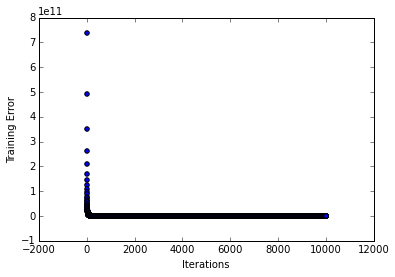

In [8]:
plt.scatter(range(10001), errList);
plt.xlabel("Iterations")
plt.ylabel("Training Error");

In [102]:
zEncodedTest = np.dot(np.transpose(W),XTest)
#XTestPred = np.dot(W, zTest)

In [103]:
CTest = [c for i,c in enumerate(C) if i not in chosenSamps]

In [104]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(np.transpose(zEncodedTest))
distances, indices = nbrs.kneighbors(np.transpose(zEncodedTest))

In [105]:
CPred = CTest #Just initializing the dimensions
from collections import Counter
for i in range(len(indices)):
    CPred[i] = Counter([CTest[x] for x in  indices[i,:]]).most_common(1)[0][0]

In [106]:
confuMatBoth = pd.DataFrame(data=0.0, 
index = ['Animal','Fungus'], 
columns = ['Animal','Fungus', 'Accuracy'])

for i in range(len(indices)):
    confuMatBoth[CTest[i]][CPred[i]] +=1

for i in range(len(confuMatBoth)):
    confuMatBoth.iloc[i]['Accuracy'] = confuMatBoth.iloc[i][i]/np.sum(confuMatBoth.iloc[i])

In [107]:
confuMatBoth

,Animal,Fungus,Accuracy
Animal,372,0,1
Fungus,0,184,1


## Encoding error

In [108]:
#W = np.load("W10000.npy")

In [109]:
#Reconstruction data
#zEncodedTest = np.dot(np.transpose(W),XTest)
XTestPred = np.dot(W, zEncodedTest)
print "Encoding Error:", "{0:.2f}".format(np.linalg.norm(XTestPred - XTest)/np.linalg.norm(XTest)), "%"

Encoding Error: 3.78 %


## Q5

### Images - Animal:1571, Fungus:1207
### Animals range(1571), Fungus range(1571, 2778)

### Training Animal Images

In [110]:
#Initialize W
trainsz = (int(1571*0.8))
hidsz = 30
maxk = 5
WA = np.asarray(np.random.uniform(0,1,size = (1024, hidsz)))
z = np.zeros((hidsz,1024))
chosenSampsA = np.random.choice(range(1571), trainsz, replace=False)
XATrain = X[chosenSampsA]
XATrain = np.transpose(XATrain)

XATest = X[[i for i in range(1571) if i not in chosenSampsA]]
XATest = np.transpose(XATest)

XATrainPred = np.zeros((1024, trainsz))

maxActivations = np.zeros((maxk,trainsz))

In [111]:
countii = 0
errList =[]
while countii < 10001:
    countii += 1
    
    z = np.dot(np.transpose(WA),XATrain)
    #z = z - np.mean(z, axis=0)
    
    for j in range(z.shape[1]):
        maxActivations[:,j] = np.argsort(z[:,j])[::-1][:maxk]
        for i in range(hidsz):
            if i not in maxActivations[:,j]:
                z[i,j] = 0
    
    XATrainPred = np.dot(WA, z)
    #XATrainPred = XATrainPred - np.mean(XATrainPred, axis=0)
    
    trErrNew = np.square(XATrain - XATrainPred)
    errList.append(np.sum(trErrNew))
    if countii % 500 == 0:
        print np.sum(trErrNew)/trainsz, datetime.datetime.now().time()
        sys.stdout.flush()
        
    errDeriv = np.dot((XATrainPred - XATrain), np.transpose(z))
    
    WA = WA - stepSize*errDeriv

271253.472098 18:44:21.902000
104410.163144 18:46:57.438000
62570.2483696 18:49:23.948000
44733.0726782 18:51:56.013000
34853.0370497 18:54:27.732000
28709.2931215 18:57:05.468000
24492.0725022 18:59:37.744000
21455.7773748 19:02:12.235000
19125.2314002 19:04:58.038000
17300.8242377 19:07:57.014000
15834.2963315 19:10:33.912000
14620.4573692 19:13:11.381000
13603.9453917 19:16:03.335000
12744.2432539 19:18:33.092000
12010.7082096 19:21:00.655000
11353.9487602 19:23:29.109000
10791.0775122 19:25:53.982000
10283.8430706 19:28:19.048000
9829.40388044 19:30:49.365000
9429.33011488 19:33:15.758000


In [9]:
#np.save("W10000AQ5", WA)
#np.save("errList10000A_Q5", errList)
#errList = np.load("errList10000A_Q5.npy")

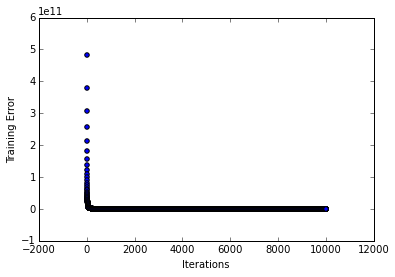

In [10]:
plt.scatter(range(10001), errList);
plt.xlabel("Iterations")
plt.ylabel("Training Error");

### Training Fungus Images

In [114]:
''#Initialize W
trainsz = (int(1207*0.8))
hidsz = 30
maxk = 5
WF = np.asarray(np.random.uniform(0,1,size = (1024, hidsz)))
z = np.zeros((hidsz,1024))
chosenSampsF = np.random.choice(range(1571, 2778), trainsz, replace=False)
XFTrain = X[chosenSampsF]
XFTrain = np.transpose(XFTrain)

XFTest = X[[i for i in range(1571, 2778) if i not in chosenSampsF]]
XFTest = np.transpose(XFTest)

XFTrainPred = np.zeros((1024, trainsz))

maxActivations = np.zeros((maxk,trainsz))

In [115]:
countii = 0
errList =[]
while countii < 10001:
    countii += 1
    
    z = np.dot(np.transpose(WF),XFTrain)
    #z = z - np.mean(z, axis=0)
    
    for j in range(z.shape[1]):
        maxActivations[:,j] = np.argsort(z[:,j])[::-1][:maxk]
        for i in range(hidsz):
            if i not in maxActivations[:,j]:
                z[i,j] = 0
    
    XFTrainPred = np.dot(WF, z)
    #XFTrainPred = XFTrainPred - np.mean(XFTrainPred, axis=0)
    
    trErrNew = np.square(XFTrain - XFTrainPred)
    errList.append(np.sum(trErrNew))
    if countii % 500 == 0:
        print np.sum(trErrNew)/trainsz, datetime.datetime.now().time()
        sys.stdout.flush()
        
    errDeriv = np.dot((XFTrainPred - XFTrain), np.transpose(z))
    
    WF = WF - stepSize*errDeriv

728990.727503 19:35:09.307000
245680.156788 19:37:01.118000
135600.261799 19:38:56.944000
90771.7132129 19:40:49.289000
67805.4373205 19:42:42.652000
53753.4347897 19:44:37.836000
44897.3493422 19:46:32.206000
38432.9419099 19:48:24.734000
33637.4243216 19:50:17.268000
30184.7782513 19:52:10.177000
27353.873276 19:54:04.357000
24921.9798185 19:55:57.105000
22860.9806883 19:57:52.345000
21252.5470586 19:59:55.647000
19823.9473147 20:01:56.683000
18646.0212065 20:04:03.880000
17575.5287135 20:05:56.656000
16644.0932013 20:07:49.899000
15784.1072048 20:09:43.236000
15056.15778 20:11:45.396000


In [11]:
#np.save("W10000FQ5", WF)
#np.save("errList10000F_Q5", errList)
#errList = np.load("errList10000F_Q5.npy")

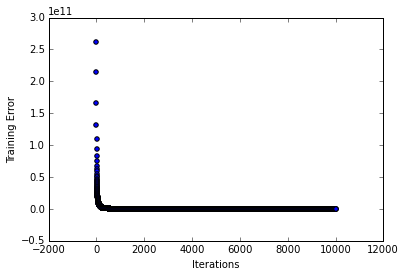

In [12]:
plt.scatter(range(10001), errList);
plt.xlabel("Iterations")
plt.ylabel("Training Error");

In [118]:
zAFEncodedTest = np.transpose(np.concatenate((np.transpose(np.dot(np.transpose(WA),XATest)), 
                                              np.transpose(np.dot(np.transpose(WF),XFTest)))))

In [119]:
CAFTest = [c for i,c in enumerate(C) if (i not in chosenSampsA) and (i not in chosenSampsF)]
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(np.transpose(zAFEncodedTest))
distances, indices = nbrs.kneighbors(np.transpose(zAFEncodedTest))

In [120]:
CAFPred = CAFTest #Init the dimensions
from collections import Counter
for i in range(len(indices)):
    CAFPred[i] = Counter([CAFTest[x] for x in  indices[i,:]]).most_common(1)[0][0]

In [121]:
confuMatIndiv = pd.DataFrame(data=0.0, 
index = ['Animal','Fungus'], 
columns = ['Animal','Fungus', 'Accuracy'])

for i in range(len(indices)):
    confuMatIndiv[CAFTest[i]][CAFPred[i]] +=1

for i in range(len(confuMatBoth)):
    confuMatIndiv.iloc[i]['Accuracy'] = confuMatIndiv.iloc[i][i]/np.sum(confuMatIndiv.iloc[i])

In [122]:
confuMatIndiv

,Animal,Fungus,Accuracy
Animal,407,0,1
Fungus,0,150,1


In [123]:
#WA = np.load("W10000AQ5.npy")
#WF = np.load("W10000FQ5.npy")
zAEncodedTest = np.dot(np.transpose(WA),XATest)
zFEncodedTest = np.dot(np.transpose(WF),XFTest)

In [124]:
#Reconstruction data
XATestPred = np.dot(WA, zAEncodedTest)
print "Encoding Error Animal:", "{0:.2f}".format(np.linalg.norm(XATestPred - XATest)/np.linalg.norm(XATest)), "%"

XFTestPred = np.dot(WF, zFEncodedTest)
print "Encoding Error Fungus:", "{0:.2f}".format(np.linalg.norm(XFTestPred - XFTest)/np.linalg.norm(XFTest)), "%"

Encoding Error Animal: 3.85 %
Encoding Error Fungus: 9.33 %


## Q6

#### As seen in the two confusion matrices above, when the encoded matrix is classified with 5NN, the classification error is zero when animal and fungus images are trained together. Classification error is also zero, when the images are trained individually.
#### Reconstruction error for encoding is slightly lower when the Animal and Fungus images are trained together. The error for Fungus images is higher than the Animal images

## Hyperparamete tuning - observing encoding error for different values of sparsity - k

In [7]:
#Function to train the autoencoder
def train_w(maxk, iters):
    countii = 0
    errList =[]
    z = np.zeros((hidsz,1024))
    maxActivations = np.zeros((maxk,trainsz))
    XTrainPred = np.zeros((1024, trainsz))
    W = np.asarray(np.random.uniform(0,1,size = (1024, hidsz)))
    
    while countii < iters:
        countii += 1

        z = np.dot(np.transpose(W),XTrain)
        #z = z - np.mean(z, axis=0)

        for j in range(z.shape[1]):
            maxActivations[:,j] = np.argsort(z[:,j])[::-1][:maxk]
            for i in range(hidsz):
                if i not in maxActivations[:,j]:
                    z[i,j] = 0

        XTrainPred = np.dot(W, z)
        #XTrainPred = XTrainPred - np.mean(XTrainPred, axis=0)

        trErrNew = np.square(XTrain - XTrainPred)
        errList.append(np.sum(trErrNew))
        if countii % 500 == 0:
            print countii, " Error:", np.sum(trErrNew)/trainsz, "k:", maxk, datetime.datetime.now().time()
            sys.stdout.flush()

        errDeriv = np.dot((XTrainPred - XTrain), np.transpose(z))

        W = W - stepSize*errDeriv
    return W, errList

In [10]:
#Initialize frixed parameters
trainsz = (int(len(X)*0.8))
hidsz = 30
stepSize = 1e-9
encErrList = []

#Run iterations
for maxk in range(2,15):
    chosenSamps = np.random.choice(len(X), trainsz, replace=False)
    XTrain = X[chosenSamps]
    XTrain = np.transpose(XTrain)
    XTest = X[[i for i in range(len(X)) if i not in chosenSamps]]
    XTest = np.transpose(XTest)
    
    W, errList = train_w(maxk, 2001)
    zEncodedTest = np.dot(np.transpose(W),XTest)
    XTestPred = np.dot(W, zEncodedTest)
    encErr = "{0:.2f}".format(np.linalg.norm(XTestPred - XTest)/np.linalg.norm(XTest))
    encErrList.append(encErr)
    print "Encoding Error for k:", maxk, encErr, "%"

500  Error: 469577.0264 k: 2 15:23:40.077000
1000  Error: 147637.834357 k: 2 15:27:37.691000
1500  Error: 74536.6904621 k: 2 15:31:29.784000
2000  Error: 46089.4182093 k: 2 15:35:17.188000
Encoding Error for k: 2 86.74 %
500  Error: 254064.841209 k: 3 15:39:04.435000
1000  Error: 85492.5709259 k: 3 15:42:58.226000
1500  Error: 46764.4493236 k: 3 15:47:09.188000
2000  Error: 31213.2783408 k: 3 15:51:29.493000
Encoding Error for k: 3 31.94 %
500  Error: 174355.228972 k: 4 15:55:50.514000
1000  Error: 65956.5031396 k: 4 15:59:47.146000
1500  Error: 39346.9823689 k: 4 16:03:31.723000
2000  Error: 28131.7031582 k: 4 16:07:14.233000
Encoding Error for k: 4 15.40 %
500  Error: 135263.4327 k: 5 16:10:57.480000
1000  Error: 57317.5509482 k: 5 16:14:39.404000
1500  Error: 36716.0015635 k: 5 16:18:21.943000
2000  Error: 27404.8886257 k: 5 16:22:04.328000
Encoding Error for k: 5 9.78 %
500  Error: 114044.469568 k: 6 16:25:46.467000
1000  Error: 52872.4804446 k: 6 16:29:28.283000
1500  Error: 35335

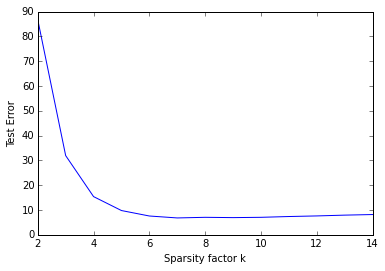

In [12]:
plt.plot(range(2,15), encErrList);
plt.xlabel('Sparsity factor k')
plt.ylabel('Test Error')